### Business Context and Problem Definition¶

## Business Context
With the increasing popularity and ease of access to online hotel booking platforms, customers tend to make reservations in advance to avoid any last-minute rush and higher prices. These online platforms offer flexible cancellation options, in some cases even a day before reservation. To compete with this, even offline bookings have increased the flexibility in cancellations. This has led to an increase in the growing number of cancellations, with one of the primary reasons being last-minute changes in travel plans. These sudden changes can result from unforeseen circumstances, such as personal emergencies, flight delays, or unexpected events at the travel destination.

Hotel booking cancellations become a crucial problem to solve as it leads to revenue loss and operational inefficiencies. The cancellation of bookings impacts a hotel on various fronts:

Loss of revenue when the hotel cannot resell the room

Additional costs of distribution channels by increasing commissions or paying for publicity to help sell these rooms

Lowering prices last minute, so the hotel can resell a room, resulting in reduced profit margins

## Problem Definition
The INN Hotels Group has been contending with the challenge of rising cancellations for nearly a year now. However, the last three months witnessed a rise in inventory loss due to cancellation rise to an all-time high of 18%. This has led to a jump in the revenue loss to an all-time high of approx. $0.25 million annually. This has significantly impacted their profit margins.

In the current context, inventory refers to a hotel room, and the inability to sell one leads to inventory loss
The group has been using heuristic mechanisms (rule and domain expert-based) to try and reduce the revenue loss due to cancellations, but this hasn't been effective so far hasn't been effective (neither efficient nor scalable), as evident from the magnitude of losses they are incurring.

The group has decided that they need a Data Science-based solution to predict the likelihood of a booking being canceled as they expect it to be more effective than their current mechanism. They hope that this proactive approach will help them significantly minimize revenue loss and improve operational efficiency.

In [4]:
# lets import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from scipy import stats

from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

In [5]:
# lets load the data

past_data = pd.read_csv('E:/DATA SCIENCE RESIDENCY/ML/case study/Day 6/INNHotelsGroup_pastdata.csv')

new_data = pd.read_csv('E:/DATA SCIENCE RESIDENCY/ML/case study/Day 6/INNHotelsGroup_newdata.csv')

In [6]:
past_data.head()

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status,rebooked
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled,NaN
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled,NaN
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled,NaN
3,INNHG_101037,23,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled,NaN
4,INNHG_101038,46,Online,1,149.40,2,2,2021-01-01,0,3,Canceled,No


In [7]:
new_data.head()

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_128127,4,Online,1,103.00,1,0,01-07-2022,1,1,Not Canceled
1,INNHG_128128,147,Online,2,103.70,2,2,01-07-2022,0,2,Not Canceled
2,INNHG_128129,43,Online,1,126.90,2,1,01-07-2022,1,2,Not Canceled
3,INNHG_128130,145,Offline,0,72.76,2,0,01-07-2022,0,1,Not Canceled
4,INNHG_128131,86,Offline,1,107.69,2,1,01-07-2022,0,2,Not Canceled


### Lets understand exactly how many bookings were cancelled & rebooked in last minute from jan 2021 to jun 2022

In [9]:
# lets see how many bookings were cancelled at last moment

past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

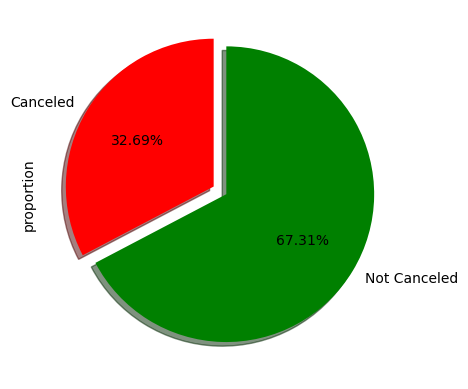

In [10]:
past_data['booking_status'].value_counts(normalize=True).plot(kind='pie',colors=['green','red'],autopct='%.2f%%',counterclock=False,startangle=90,explode=[0,0.1],shadow=True)
plt.show()

In [11]:
# lets see out of cancelled bookings how many were rebooked

past_data[past_data['booking_status']=='Canceled']['rebooked'].value_counts(normalize=True)

rebooked
No     0.800723
Yes    0.199277
Name: proportion, dtype: float64

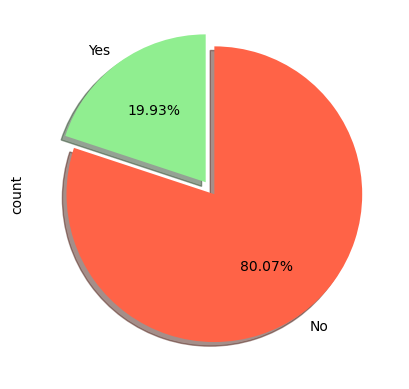

In [12]:
past_data[past_data['booking_status']=='Canceled']['rebooked'].value_counts().plot(kind='pie',colors=['tomato','lightgreen'],autopct='%.2f%%',counterclock=False,startangle=90,explode=[0,0.1],shadow=True)
plt.show()

#### INFERENCE 
* Here we can see out of all the bookings ~33% bookings are being cancelled at last moment & out of those cancelled bookings only ~20% were rebooked,which leads to huge inventory loss.

In [14]:
# we can remove the 'rebooked' from data as this information will not be available beforehand.

past_data.drop(columns='rebooked',inplace=True)

In [15]:
past_data.head()

,booking_id,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
0,INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
1,INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
2,INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled
3,INNHG_101037,23,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled
4,INNHG_101038,46,Online,1,149.40,2,2,2021-01-01,0,3,Canceled


In [16]:
# we can also make booking id as index column/or remove as these are just unique identifiers of bookings(rows)

past_data.set_index('booking_id',inplace=True)
new_data.set_index('booking_id',inplace=True)

In [17]:
past_data.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101034,0,Online,0,85.03,1,1,2021-01-01,0,0,Not Canceled
INNHG_101035,34,Online,2,125.10,2,2,2021-01-01,0,0,Not Canceled
INNHG_101036,24,Online,1,71.69,2,2,2021-01-01,0,0,Not Canceled
INNHG_101037,23,Online,0,84.70,1,2,2021-01-01,0,0,Not Canceled
INNHG_101038,46,Online,1,149.40,2,2,2021-01-01,0,3,Canceled


In [18]:

new_data.head()

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_128127,4,Online,1,103.00,1,0,01-07-2022,1,1,Not Canceled
INNHG_128128,147,Online,2,103.70,2,2,01-07-2022,0,2,Not Canceled
INNHG_128129,43,Online,1,126.90,2,1,01-07-2022,1,2,Not Canceled
INNHG_128130,145,Offline,0,72.76,2,0,01-07-2022,0,1,Not Canceled
INNHG_128131,86,Offline,1,107.69,2,1,01-07-2022,0,2,Not Canceled


#### Explore the data

In [20]:
print('No. of rows',past_data.shape[0])
print('No. of columns',past_data.shape[1])

No. of rows 27093
No. of columns 10


In [21]:
# check the balance of target variable

past_data['booking_status'].value_counts(normalize=True)

booking_status
Not Canceled    0.673089
Canceled        0.326911
Name: proportion, dtype: float64

In [22]:
# five point summary

past_data.describe().T

,count,mean,std,min,25%,50%,75%,max
lead_time,27093.0,81.605249,84.901428,0.0,14.0,55.0,118.0,443.0
no_of_special_requests,27093.0,0.556454,0.743715,0.0,0.0,0.0,1.0,5.0
avg_price_per_room,27093.0,101.025910,34.557289,0.0,79.0,97.0,119.0,540.0
no_of_adults,27093.0,1.825822,0.512182,0.0,2.0,2.0,2.0,4.0
no_of_weekend_nights,27093.0,0.778319,0.861787,0.0,0.0,1.0,1.0,6.0
required_car_parking_space,27093.0,0.028864,0.167426,0.0,0.0,0.0,0.0,1.0
no_of_week_nights,27093.0,2.171373,1.386023,0.0,1.0,2.0,3.0,17.0


#### INFERENCE:

* Most bookings are made within a few months (average 81.6 days), but some customers plan up to 443 days in advance, indicating a mix of last-minute and long-term planners.
* The average number of special requests is 0.56, with a standard deviation of 0.74. Most bookings have no special requests (median = 0), but a small group makes up to 5 requests, indicating a segment with higher customization needs.
* Prices vary widely (average 101.03, max 540), suggesting a mix of budget and luxury accommodations, possibly influenced by room type or season.

In [24]:
past_data.columns

Index(['lead_time', 'market_segment_type', 'no_of_special_requests',
       'avg_price_per_room', 'no_of_adults', 'no_of_weekend_nights',
       'arrival_date', 'required_car_parking_space', 'no_of_week_nights',
       'booking_status'],
      dtype='object')

In [25]:
# Explore the columns one by one

num_cols = ['lead_time','avg_price_per_room','no_of_week_nights']
cat_cols = ['market_segment_type','no_of_special_requests','no_of_adults','no_of_weekend_nights','required_car_parking_space','booking_status']

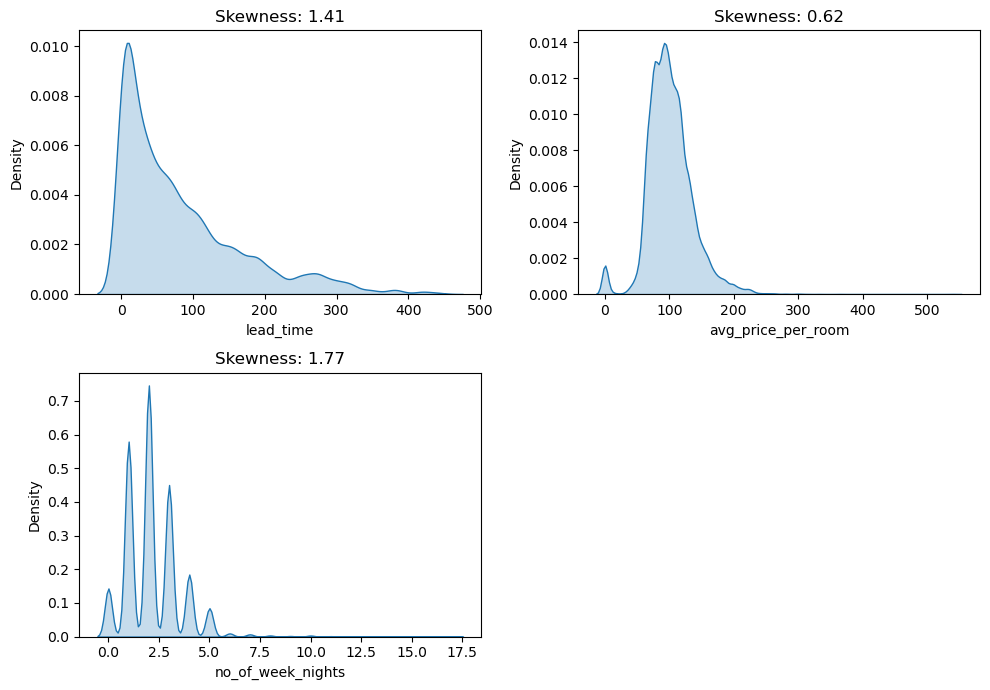

In [26]:
# Univariate analysis

# explore num columns
t=1 
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.kdeplot(data=past_data,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()
    

#### INFERENCE:

* Lead time is exceeding 300 days!!! are there bookings which have been made 1 year prior?
* There are bookings with avg price per room 0.
* There are customers with very long stays upto 17 weeknights.

In [28]:
past_data[past_data['avg_price_per_room']==0]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_101089,9,Online,2,0.0,2,1,2021-01-01,0,0,Not Canceled
INNHG_101119,24,Online,1,0.0,2,1,2021-01-01,0,0,Not Canceled
INNHG_101140,145,Online,1,0.0,2,0,2021-01-05,0,0,Not Canceled
INNHG_101150,4,Online,1,0.0,1,0,2021-01-05,0,1,Not Canceled
INNHG_101179,145,Online,1,0.0,2,0,2021-01-05,0,0,Not Canceled
...,...,...,...,...,...,...,...,...,...,...
INNHG_127432,3,Online,0,0.0,2,0,2022-06-24,0,0,Not Canceled
INNHG_127463,0,Online,0,0.0,1,0,2022-06-24,0,2,Not Canceled
INNHG_127773,3,Online,0,0.0,1,1,2022-06-27,0,0,Not Canceled


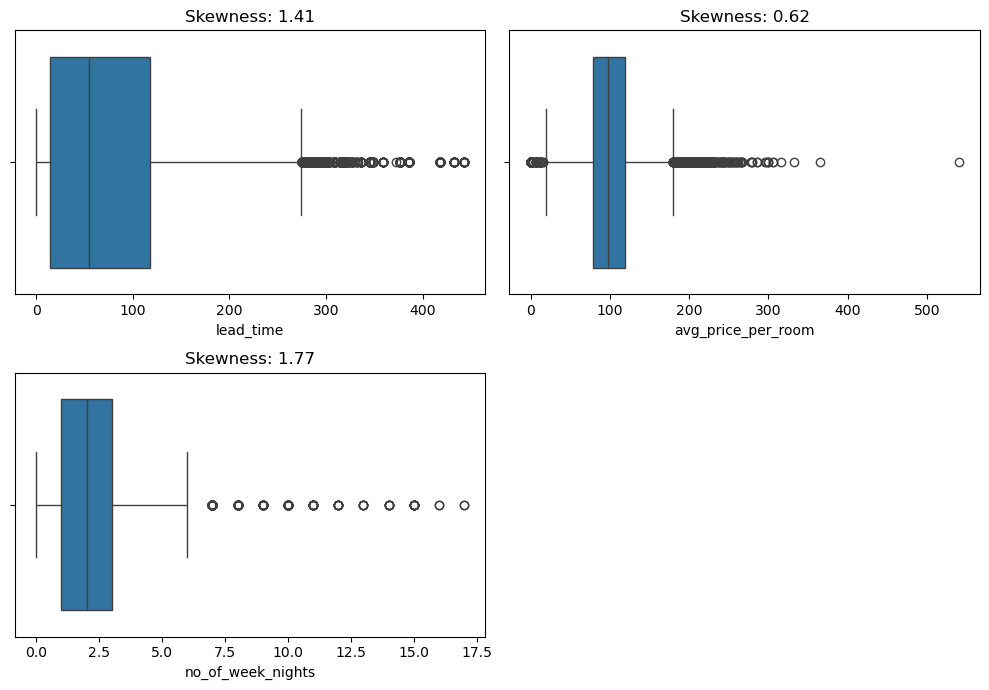

In [29]:
# for outliers

t=1 
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()

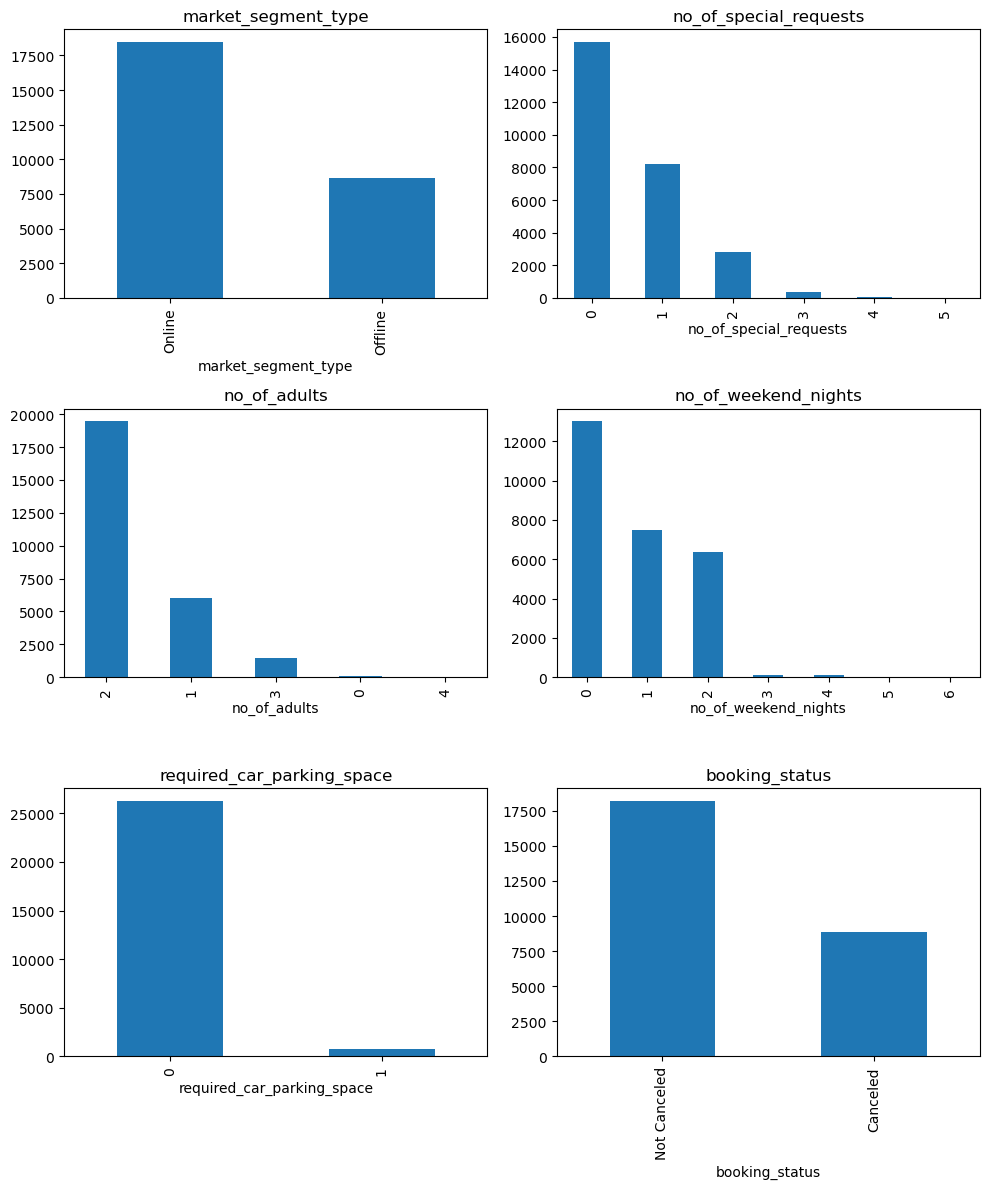

In [30]:
# explore category columnns

t=1
plt.figure(figsize=(10,12))
for i in cat_cols:
    plt.subplot(3,2,t)
    past_data[i].value_counts().plot(kind='bar')
    plt.title(i)
    t+=1
plt.tight_layout()
plt.show()
    

#### INFERENCE:

* Most of the bookings have been made online.
* Mostly there are no or 1 special requests.
* In most of the bookings no. of adults are 1 or 2.
* In most of the bookings maximum weekend nights are 2.
* In most of the bookings do not require parking space.

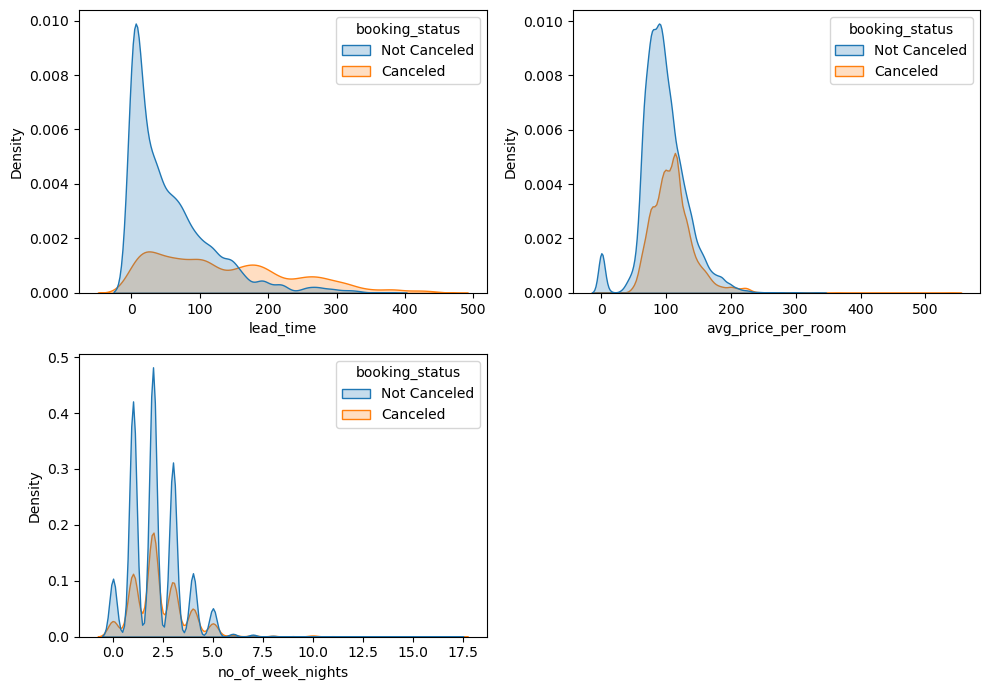

In [32]:
# Bivariate analysis

t=1 
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    sns.kdeplot(data=past_data,x=i,fill=True,hue='booking_status')
    t+=1
plt.tight_layout()
plt.show()

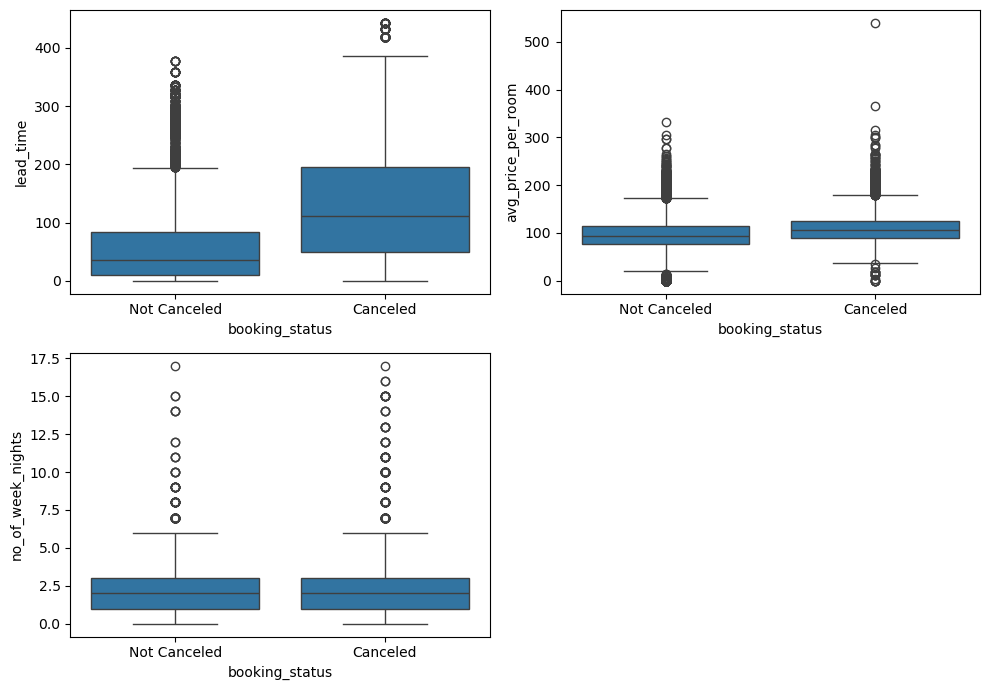

In [33]:
t=1 
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    sns.boxplot(data=past_data,x='booking_status',y=i)
    t+=1
plt.tight_layout()
plt.show()

In [34]:
# Lets investigate lead_time and avg_price_per_room with booking_status

past_data.groupby(by='booking_status')['lead_time'].mean()

booking_status
Canceled        134.035791
Not Canceled     56.140382
Name: lead_time, dtype: float64

In [35]:
samp1 = past_data[past_data['booking_status']=='Canceled']['lead_time']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['lead_time']


In [36]:
# We will go with 2 sample t-test

# Assumption 1 : Data must be normal

print(stats.shapiro(samp1))
print(stats.shapiro(samp2))

# Assumption 2 : Variances are equal

print(stats.levene(samp1,samp2))

# Data is not normal and variances are also not equal

ShapiroResult(statistic=0.9387743609879114, pvalue=4.865435517353332e-51)
ShapiroResult(statistic=0.8214888949700189, pvalue=7.235137959871973e-88)
LeveneResult(statistic=3210.120590252021, pvalue=0.0)


In [37]:
# Lets go with non parametric test(Mannwhitneyu test)

pvalue = stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if pvalue<0.05:
    print('Reject the Ho')
else:
    print('Fail to reject Ho')                  

# We can conclude that avg_lead_time of canceled bookings are greater than not canceled bookings with 95% CI.

Reject the Ho


In [38]:
# avg_price vs booking_status
past_data.groupby(by='booking_status')['avg_price_per_room'].mean()

booking_status
Canceled        109.722152
Not Canceled     96.802253
Name: avg_price_per_room, dtype: float64

In [39]:
samp1 = past_data[past_data['booking_status']=='Canceled']['avg_price_per_room']
samp2 = past_data[past_data['booking_status']=='Not Canceled']['avg_price_per_room']


In [40]:
# We will go with 2 sample t-test

# Assumption 1 : Data must be normal

print(stats.shapiro(samp1))
print(stats.shapiro(samp2))

# Assumption 2 : Variances are equal

print(stats.levene(samp1,samp2))

# Data is not normal and variances are also not equal

ShapiroResult(statistic=0.9253871055438694, pvalue=1.5094155400796404e-54)
ShapiroResult(statistic=0.9534249109201302, pvalue=3.2212372568679052e-59)
LeveneResult(statistic=29.227364523829735, pvalue=6.490728476679038e-08)


In [41]:
# Lets go with non parametric test(Mannwhitneyu test)

pvalue = stats.mannwhitneyu(samp1,samp2,alternative='greater')[1]

if pvalue<0.05:
    print('Reject the Ho')
else:
    print('Fail to reject Ho')                  

# hence we can conclude the avg price of canceled bookings is greater than avg price of not canceled bookings

Reject the Ho


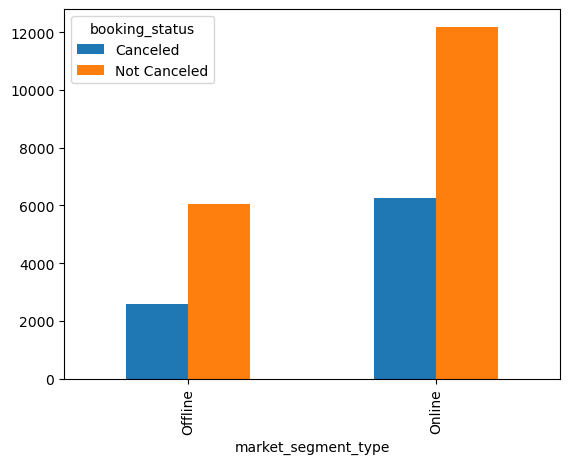

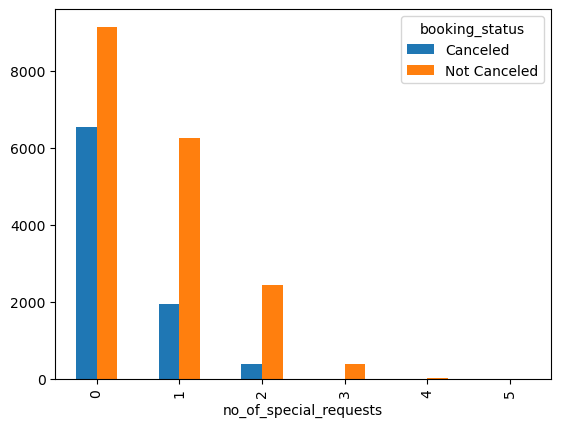

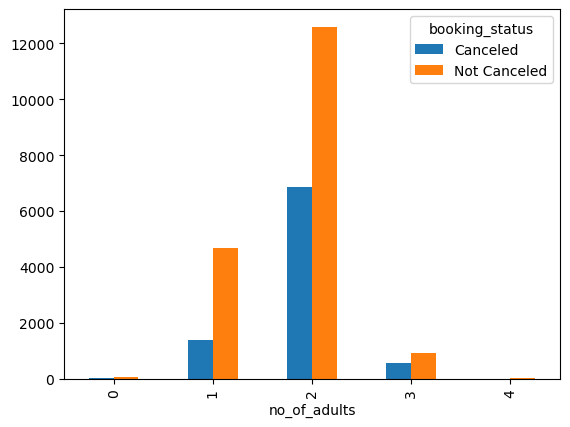

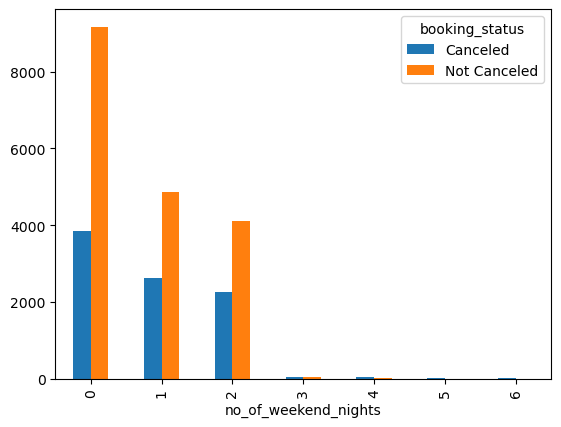

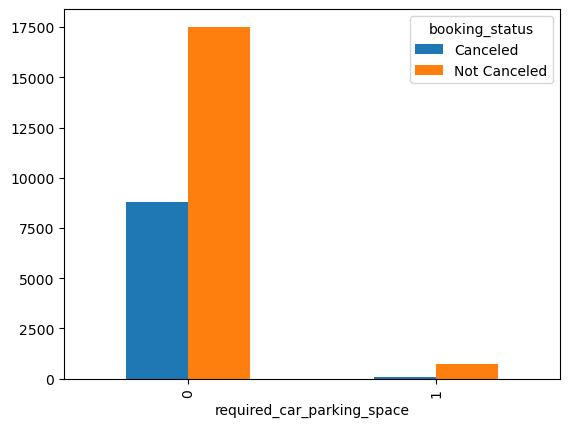

In [42]:
# Cat columns vs target variable

for i in cat_cols:
    if i!='booking_status':
         pd.crosstab(past_data[i],past_data['booking_status']).plot(kind='bar')
    plt.show()

In [43]:
# Lets do chi-square contingency test to make final conclusions

# Ho: columns are independent
# Ha: columns are dependent

for i in cat_cols:
    if i!='booking_status':
        contingency_table = pd.crosstab(past_data[i],past_data['booking_status'])
        print(i,':',stats.chi2_contingency(contingency_table)[1])

# We reject Ho in all the cases as p-value is less than 0.05.

market_segment_type : 7.806389643886697e-11
no_of_special_requests : 0.0
no_of_adults : 1.4411855115006094e-73
no_of_weekend_nights : 5.324997086476798e-43
required_car_parking_space : 5.626905783478662e-49


#### (Just for reference)

Inferential statistics (Num vs Num)

In [45]:
past_data['lead_time'].corr(past_data['avg_price_per_room'])

-0.02928918726851993

In [46]:
# Parametric test  (Pearson's correlation test)

# Assumption: Data must be normal.

# Ho: No correlation
# Ha: correlation

stats.pearsonr(past_data['lead_time'],past_data['avg_price_per_room'])            # here we already knew that data is not normal(so can't use this,will go with spearman's test),still performing this just for reference.

PearsonRResult(statistic=-0.029289187268519895, pvalue=1.4227003552821461e-06)

In [47]:
# Non Parametric test  (spearman's correlation test)--> it has no assumptions

# Assumption: Data must be normal.

# Ho: No correlation
# Ha: correlation

stats.spearmanr(past_data['lead_time'],past_data['avg_price_per_room'])

# Failed to reject the Ho--> which means there is no correlation

SignificanceResult(statistic=0.00683549727618094, pvalue=0.26055481328066965)

#### Data preprocessing

In [49]:
past_data.duplicated().sum()

8438

In [50]:
# Although it shows duplicates but each row has its own booking_id so we will assume there are no duplicates

In [51]:
# check for missing values

past_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [52]:
new_data.isnull().sum()

lead_time                     0
market_segment_type           0
no_of_special_requests        0
avg_price_per_room            0
no_of_adults                  0
no_of_weekend_nights          0
arrival_date                  0
required_car_parking_space    0
no_of_week_nights             0
booking_status                0
dtype: int64

In [53]:
# For now lets treat only the extreme outlier in avg_price_per_room

past_data[past_data['avg_price_per_room']>400]

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,arrival_date,required_car_parking_space,no_of_week_nights,booking_status
booking_id,,,,,,,,,,
INNHG_119173,35,Offline,0,540.0,2,0,2022-03-25,0,1,Canceled


In [54]:
past_data.drop(index='INNHG_119173',inplace=True)

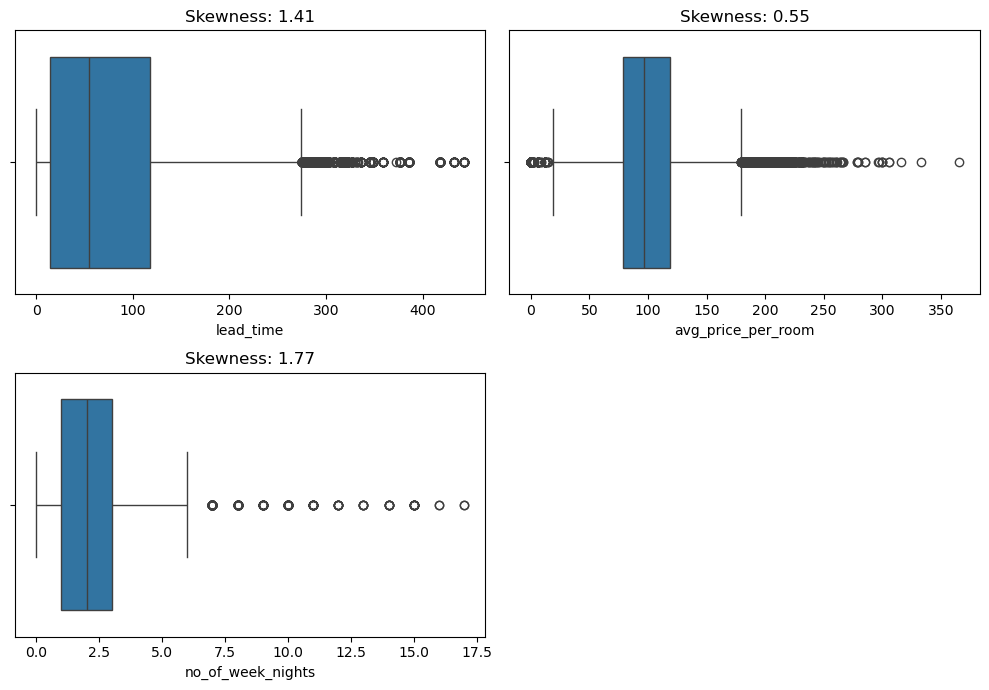

In [55]:
# check for outliers
t=1 
plt.figure(figsize=(10,7))
for i in num_cols:
    plt.subplot(2,2,t)
    plt.title(f'Skewness: {round(past_data[i].skew(),2)}')
    sns.boxplot(data=past_data,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()


In [56]:
# split the data into train and test before we do any trasnformation

x_train = past_data.drop(columns='booking_status')
y_train = past_data['booking_status'].map({'Not Canceled':0,'Canceled':1})

x_test = new_data.drop(columns='booking_status')
y_test = new_data['booking_status'].map({'Not Canceled':0,'Canceled':1})

In [57]:
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)


(27092, 9) (27092,) (3583, 9) (3583,)


#### Feature Encoding

In [59]:
x_train.dtypes

lead_time                       int64
market_segment_type            object
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
arrival_date                   object
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

In [60]:
x_train['market_segment_type'].value_counts()

market_segment_type
Online     18456
Offline     8636
Name: count, dtype: int64

In [61]:
x_train['market_segment_type'] = x_train['market_segment_type'].map({'Online':1,'Offline':0})

x_test['market_segment_type'] = x_test['market_segment_type'].map({'Online':1,'Offline':0})

In [62]:
x_train['market_segment_type'].value_counts()

market_segment_type
1    18456
0     8636
Name: count, dtype: int64

In [63]:
x_test['market_segment_type'].value_counts()

market_segment_type
1    3105
0     478
Name: count, dtype: int64

#### Feature Engineering

In [143]:
x_train['arrival_date']

booking_id
INNHG_101034    2021-01-01
INNHG_101035    2021-01-01
INNHG_101036    2021-01-01
INNHG_101037    2021-01-01
INNHG_101038    2021-01-01
                   ...    
INNHG_128122    2022-06-30
INNHG_128123    2022-06-30
INNHG_128124    2022-06-30
INNHG_128125    2022-06-30
INNHG_128126    2022-06-30
Name: arrival_date, Length: 27092, dtype: object

In [145]:
x_train.dtypes

lead_time                       int64
market_segment_type             int64
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
arrival_date                   object
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

In [147]:
x_train.drop(columns='arrival_date',inplace=True)
x_test.drop(columns='arrival_date',inplace=True)

In [149]:
x_train.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights
booking_id,,,,,,,,
INNHG_101034,0,1,0,85.03,1,1,0,0
INNHG_101035,34,1,2,125.10,2,2,0,0


In [151]:
x_train.dtypes

lead_time                       int64
market_segment_type             int64
no_of_special_requests          int64
avg_price_per_room            float64
no_of_adults                    int64
no_of_weekend_nights            int64
required_car_parking_space      int64
no_of_week_nights               int64
dtype: object

#### Feature Transformation

In [156]:
num_cols

['lead_time', 'avg_price_per_room', 'no_of_week_nights']

In [158]:
# Lets use yeo-johnson transformation on numeric columns
# This way the model will fit better and effect of outliers will also be reduce.

pt = PowerTransformer(standardize=False)

x_train[['lead_time', 'avg_price_per_room']] = pt.fit_transform(x_train[['lead_time', 'avg_price_per_room']])
x_test[['lead_time', 'avg_price_per_room']] = pt.fit_transform(x_test[['lead_time', 'avg_price_per_room']])

In [160]:
x_train.head(2)

,lead_time,market_segment_type,no_of_special_requests,avg_price_per_room,no_of_adults,no_of_weekend_nights,required_car_parking_space,no_of_week_nights
booking_id,,,,,,,,
INNHG_101034,0.000000,1,0,56.295048,1,1,0,0
INNHG_101035,5.761007,1,2,79.293092,2,2,0,0


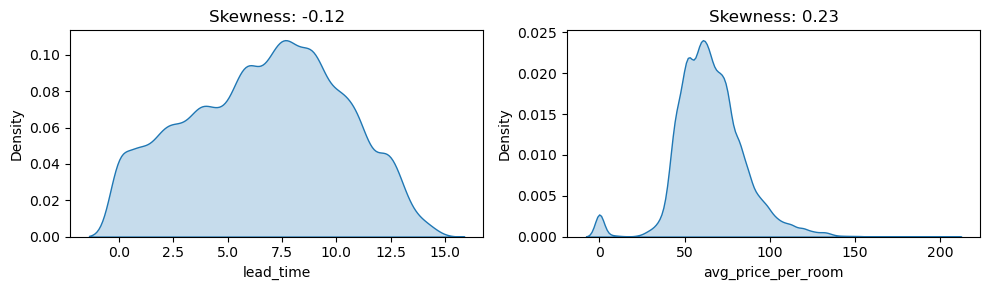

In [163]:

t=1 
plt.figure(figsize=(10,3))
for i in ['lead_time', 'avg_price_per_room']:
    plt.subplot(1,2,t)
    plt.title(f'Skewness: {round(x_train[i].skew(),2)}')
    sns.kdeplot(data=x_train,x=i,fill=True)
    t+=1
plt.tight_layout()
plt.show()
    

### Modelling

In [165]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,AdaBoostClassifier,
                             GradientBoostingClassifier,VotingClassifier,
                             StackingClassifier)
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score,precision_score,recall_score,
                            f1_score,cohen_kappa_score,confusion_matrix,
                            classification_report,roc_auc_score,roc_curve)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score,KFold

In [167]:
# Create a function to validate models
m = []
acu = []
rec = []
pre = []
f1 = []
kap = []

def model_validation(model,trainx,trainy,testx,testy):
    mod = model
    mod.fit(trainx,trainy)
    pred_s = mod.predict_proba(testx)[:,1]
    pred_h = mod.predict(testx)
    
    print(confusion_matrix(testy,pred_h))
    print(classification_report(testy,pred_h))
    
    fpr,tpr,thres = roc_curve(testy,pred_s)
    plt.plot(fpr,tpr)
    plt.plot([0,1],[0,1],color='red',ls='--')
    plt.title(f'ROC AUC: {round(roc_auc_score(testy,pred_s),3)}')
    plt.show()
    
    response = input('Do you want to save this model? Y/N')
    
    if response.lower() == 'y':
        global scorecard
        m.append(str(model))
        acu.append(accuracy_score(testy,pred_h))
        rec.append(recall_score(testy,pred_h))
        pre.append(precision_score(testy,pred_h))
        f1.append(f1_score(testy,pred_h))
        kap.append(cohen_kappa_score(testy,pred_h))
        
        scorecard = pd.DataFrame({'Model':m,'Accuracy':acu,'Recall':rec,
                                 'Precison':pre,'F1 Score':f1,'Cohen-Kappa':kap})
    else:
        return


### Logistic Regression(Base Model)

[[ 891 1492]
 [  61 1139]]
              precision    recall  f1-score   support

           0       0.94      0.37      0.53      2383
           1       0.43      0.95      0.59      1200

    accuracy                           0.57      3583
   macro avg       0.68      0.66      0.56      3583
weighted avg       0.77      0.57      0.55      3583



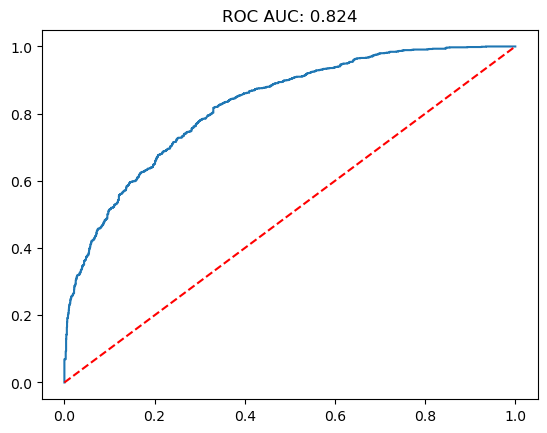

Do you want to save this model? Y/N y


In [171]:
model_validation(LogisticRegression(class_weight='balanced'),x_train,y_train,x_test,y_test)

In [173]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.566564,0.949167,0.432915,0.594623,0.249279


### Naive Bayes

[[1124 1259]
 [ 123 1077]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62      2383
           1       0.46      0.90      0.61      1200

    accuracy                           0.61      3583
   macro avg       0.68      0.68      0.61      3583
weighted avg       0.75      0.61      0.62      3583



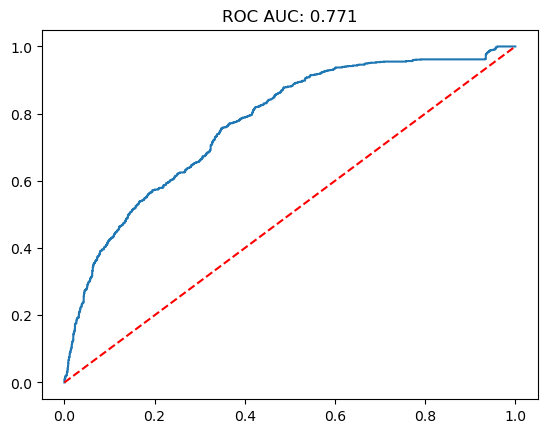

Do you want to save this model? Y/N y


In [176]:
model_validation(GaussianNB(),x_train,y_train,x_test,y_test)

[[1270 1113]
 [ 187 1013]]
              precision    recall  f1-score   support

           0       0.87      0.53      0.66      2383
           1       0.48      0.84      0.61      1200

    accuracy                           0.64      3583
   macro avg       0.67      0.69      0.64      3583
weighted avg       0.74      0.64      0.64      3583



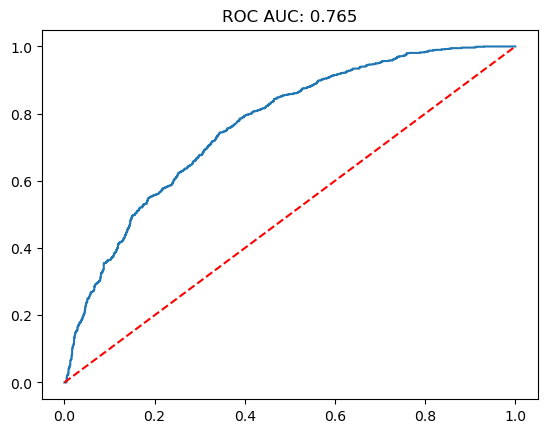

Do you want to save this model? Y/N y


In [178]:
model_validation(MultinomialNB(),x_train,y_train,x_test,y_test)

[[2383    0]
 [1200    0]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80      2383
           1       0.00      0.00      0.00      1200

    accuracy                           0.67      3583
   macro avg       0.33      0.50      0.40      3583
weighted avg       0.44      0.67      0.53      3583



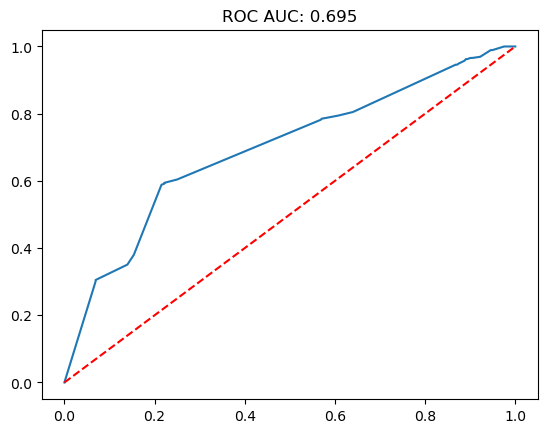

Do you want to save this model? Y/N y


In [180]:
model_validation(BernoulliNB(),x_train,y_train,x_test,y_test)

In [182]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.566564,0.949167,0.432915,0.594623,0.249279
1,GaussianNB(),0.614290,0.897500,0.461045,0.609163,0.298932
2,MultinomialNB(),0.637176,0.844167,0.476482,0.609140,0.316488
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000


### Decision Tree

[[1561  822]
 [ 285  915]]
              precision    recall  f1-score   support

           0       0.85      0.66      0.74      2383
           1       0.53      0.76      0.62      1200

    accuracy                           0.69      3583
   macro avg       0.69      0.71      0.68      3583
weighted avg       0.74      0.69      0.70      3583



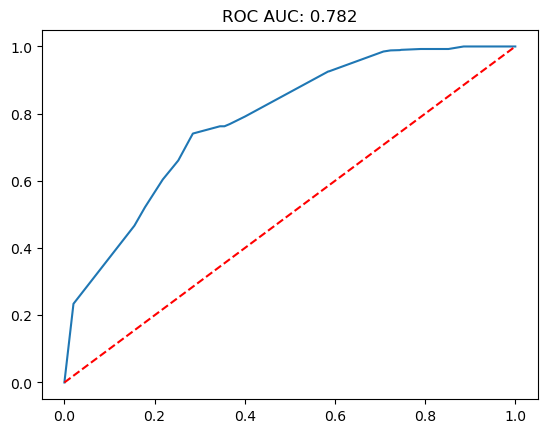

Do you want to save this model? Y/N y


In [186]:
model_validation(DecisionTreeClassifier(max_depth=5),x_train,y_train,x_test,y_test)

In [188]:
# Fine tune DT

grid = {'max_depth':[4,5,6,7,8,9,10]}

gscv = GridSearchCV(estimator=DecisionTreeClassifier(),cv=5,scoring='roc_auc',
                   verbose=1,param_grid=grid)

In [190]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10]},
             scoring='roc_auc', verbose=1)

In [192]:
gscv.best_params_

{'max_depth': 6}

[[1420  963]
 [ 206  994]]
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      2383
           1       0.51      0.83      0.63      1200

    accuracy                           0.67      3583
   macro avg       0.69      0.71      0.67      3583
weighted avg       0.75      0.67      0.68      3583



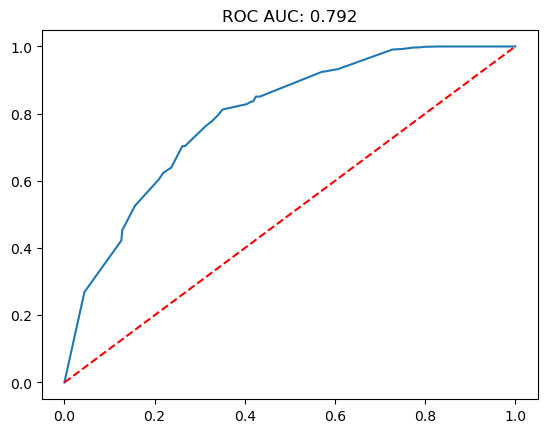

Do you want to save this model? Y/N y


In [194]:
model_validation(DecisionTreeClassifier(**gscv.best_params_),x_train,y_train,x_test,y_test)

### Random Forest

In [196]:
grid = {'n_estimators':[110,120,130],
       'max_depth':[4,5,6]}

gscv = GridSearchCV(estimator=RandomForestClassifier(),cv=5,scoring='roc_auc',
                   verbose=1,param_grid=grid)

In [198]:
gscv.fit(x_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 5, 6],
                         'n_estimators': [110, 120, 130]},
             scoring='roc_auc', verbose=1)

In [200]:
gscv.best_params_

{'max_depth': 6, 'n_estimators': 110}

[[1447  936]
 [ 194 1006]]
              precision    recall  f1-score   support

           0       0.88      0.61      0.72      2383
           1       0.52      0.84      0.64      1200

    accuracy                           0.68      3583
   macro avg       0.70      0.72      0.68      3583
weighted avg       0.76      0.68      0.69      3583



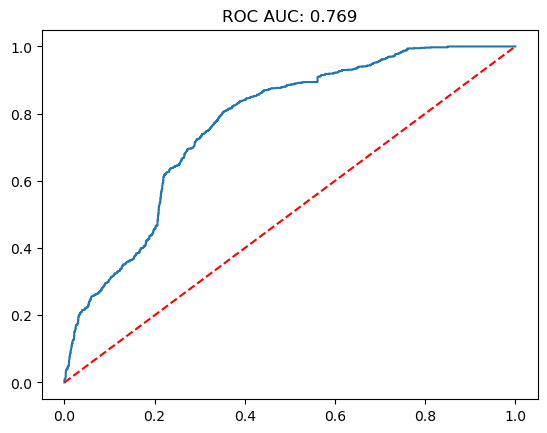

Do you want to save this model? Y/N y


In [202]:
model_validation(RandomForestClassifier(**gscv.best_params_),
                 x_train,y_train,x_test,y_test)

### Ada Boost

[[1127 1256]
 [ 132 1068]]
              precision    recall  f1-score   support

           0       0.90      0.47      0.62      2383
           1       0.46      0.89      0.61      1200

    accuracy                           0.61      3583
   macro avg       0.68      0.68      0.61      3583
weighted avg       0.75      0.61      0.61      3583



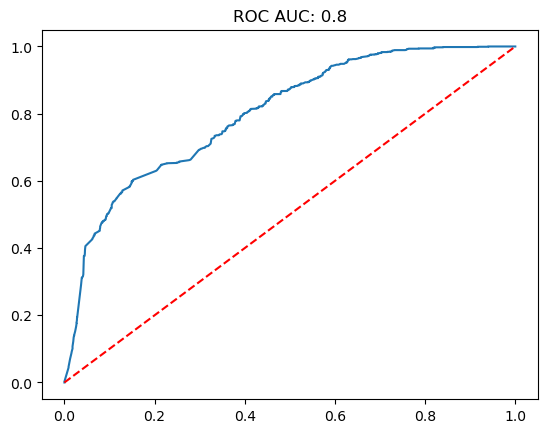

Do you want to save this model? Y/N y


In [205]:
model_validation(AdaBoostClassifier(n_estimators=150,learning_rate=0.1),
                x_train,y_train,x_test,y_test)

### XGBoost

[[1177 1206]
 [ 125 1075]]
              precision    recall  f1-score   support

           0       0.90      0.49      0.64      2383
           1       0.47      0.90      0.62      1200

    accuracy                           0.63      3583
   macro avg       0.69      0.69      0.63      3583
weighted avg       0.76      0.63      0.63      3583



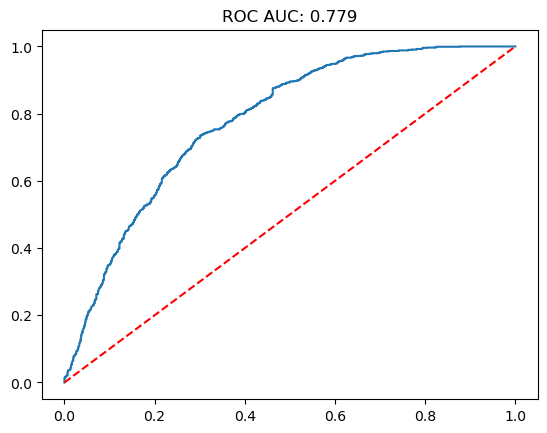

Do you want to save this model? Y/N y


In [207]:
model_validation(XGBClassifier(n_estimators=80,max_depth=9,learning_rate=0.5),
                x_train,y_train,x_test,y_test)

In [209]:
grid={'n_estimators':[70,80],
     'learning_rate':[0.1,0.7,0.5],
     'max_depth':[6,7,8,9]}

In [211]:
gscv=GridSearchCV(estimator=XGBClassifier(),param_grid=grid,cv=KFold(n_splits=7,shuffle=True,random_state=2),scoring='f1',verbose=1)

In [213]:
gscv.fit(x_train,y_train)

Fitting 7 folds for each of 24 candidates, totalling 168 fits


GridSearchCV(cv=KFold(n_splits=7, random_state=2, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.7, 0.5],
                         'max_depth': [6, 7, 8, 9], 'n_estimators': [70, 80]},
             scoring='f1', verbose=1)

In [215]:
gscv.best_score_

0.8115865560238872

In [217]:
gscv.best_params_

{'learning_rate': 0.5, 'max_depth': 9, 'n_estimators': 80}

[[1177 1206]
 [ 125 1075]]
              precision    recall  f1-score   support

           0       0.90      0.49      0.64      2383
           1       0.47      0.90      0.62      1200

    accuracy                           0.63      3583
   macro avg       0.69      0.69      0.63      3583
weighted avg       0.76      0.63      0.63      3583



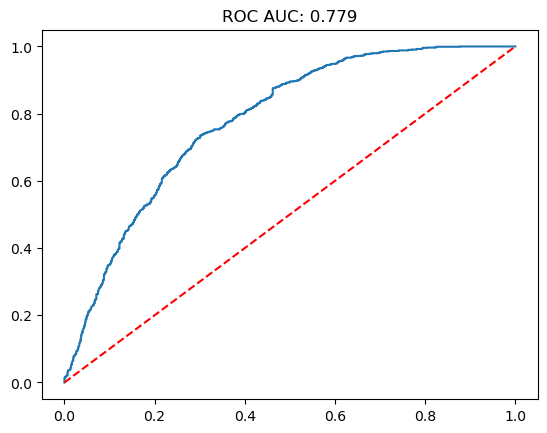

Do you want to save this model? Y/N y


In [219]:
model_validation(XGBClassifier(**gscv.best_params_),
                 x_train,y_train,x_test,y_test)

In [223]:
scorecard

,Model,Accuracy,Recall,Precison,F1 Score,Cohen-Kappa
0,LogisticRegression(class_weight='balanced'),0.566564,0.949167,0.432915,0.594623,0.249279
1,GaussianNB(),0.614290,0.897500,0.461045,0.609163,0.298932
2,MultinomialNB(),0.637176,0.844167,0.476482,0.609140,0.316488
3,BernoulliNB(),0.665085,0.000000,0.000000,0.000000,0.000000
4,DecisionTreeClassifier(max_depth=5),0.691041,0.762500,0.526770,0.623085,0.375813
5,DecisionTreeClassifier(max_depth=6),0.673737,0.828333,0.507920,0.629712,0.366788
6,"RandomForestClassifier(max_depth=6, n_estimato...",0.684622,0.838333,0.518023,0.640356,0.386267
7,"AdaBoostClassifier(learning_rate=0.1, n_estima...",0.612615,0.890000,0.459552,0.606129,0.294470
8,"XGBClassifier(base_score=None, booster=None, c...",0.628524,0.895833,0.471285,0.617639,0.318526
9,"XGBClassifier(base_score=None, booster=None, c...",0.628524,0.895833,0.471285,0.617639,0.318526


In [221]:
cross_val_score(estimator=XGBClassifier(**gscv.best_params_),X=x_train,y=y_train,cv=KFold(n_splits=7,shuffle=True,random_state=2),scoring='roc_auc',verbose=1)

array([0.94008543, 0.93857734, 0.93900335, 0.93682184, 0.94434476,
       0.9452575 , 0.93868397])

### Deployment

In [226]:
final_model= XGBClassifier(**gscv.best_params_)
final_model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [228]:
lt=30
mst=1
spcl=1
price=200
adults=2
wkend=2
park=0
wk=0


In [230]:
tran_data=pt.transform([[lt,price]])
lt_t=tran_data[0][0]
price_t=tran_data[0][1]

In [232]:
final_model.predict([[lt_t,mst,spcl,price_t,adults,wkend,park,wk]])

array([0])

In [234]:
final_model.predict_proba([[lt_t,mst,spcl,price_t,adults,wkend,park,wk]])[:,1]

array([0.11004141], dtype=float32)

### Business Interpretation

In [237]:
f1_data=pd.DataFrame(final_model.feature_importances_,index=x_train.columns).sort_values(by=0,ascending=False)
f1_data

,0
market_segment_type,0.345702
required_car_parking_space,0.229031
no_of_special_requests,0.154326
lead_time,0.084419
no_of_adults,0.061135
avg_price_per_room,0.053059
no_of_weekend_nights,0.039008
no_of_week_nights,0.033320


<Axes: >

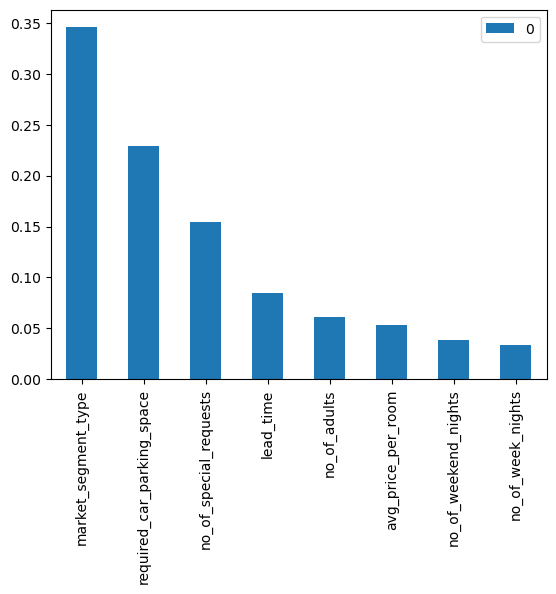

In [239]:
f1_data.plot(kind='bar')

In [241]:
# lets save the fitted model and Transformer instance
import pickle 

In [243]:
with open('final_model_xgb.pkl','wb') as file:
    pickle.dump(final_model,file)

In [245]:
with open('transformer.pkl','wb') as file:
    pickle.dump(pt,file)